# DFT & IDFT parallel implementation in PETSc

## a) PETSc config

PETSc setup in optimized mode using the following set of commands from the [PETSc documentation](https://petsc.org/release/install/):

```
cd ${HOME}

git clone -b release https://gitlab.com/petsc/petsc.git petsc

./configure --with-scalar-type=complex --with-debugging=0 ...

make PETSC_DIR=${HOME}/petsc PETSC_ARCH=arch-linux-c-opt all

make PETSC_DIR=${HOME}/petsc PETSC_ARCH=arch-linux-c-opt check
```

## b) PETSc code

Code is divided into 4 files:

### [dft_lib.c](dft_lib.c)
Contains core DFT and IDFT algorithm logic and is used in all of the other C code.

### [dft_random.c](dft_random.c)
Contains logic for benchmarking with random input of different size (N).

### [dft_numpy.c](dft_numpy.c)
Contains logic for loading `numpy` generated input and saving results for easy `matplotlib` plotting.

### [dft_idft.c](dft_idft.c)
Contains simple DFT & IDFT test.

## 1. Compute and plot the DFT amplitude spectrum (correctness check)

This section contains Python code from the DFT section of [Python Numerical Methods](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html). It is used to generate the same input signal waves, so we can test the PETSc DFT implementation on some real example and simply check for correctness.

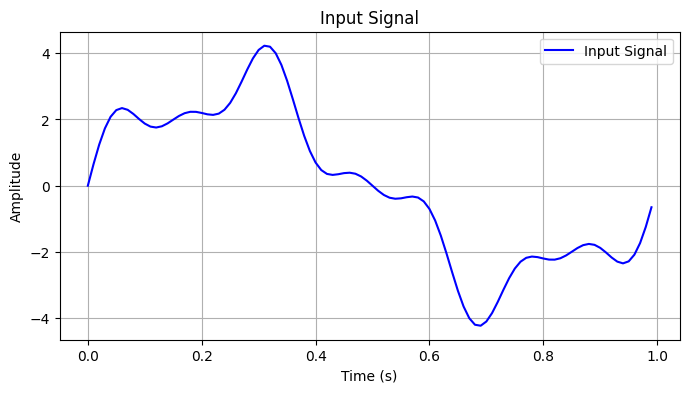

Input signal saved to 'input_signal.txt'


In [1]:
# Generating input

import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
sr = 100               # Sampling rate: 100 samples per second
ts = 1.0 / sr          # Sampling interval
t = np.arange(0, 1, ts)  # Time vector from 0 to 1 second

# Create the input signal (a sum of sine waves)
x = 3 * np.sin(2 * np.pi * 1 * t)        # Frequency = 1 Hz, amplitude = 3
x += np.sin(2 * np.pi * 4 * t)           # Frequency = 4 Hz, amplitude = 1
x += 0.5 * np.sin(2 * np.pi * 7 * t)     # Frequency = 7 Hz, amplitude = 0.5

# Plot the input signal
fig = plt.figure(figsize=(8, 4))
plt.plot(t, x, 'b-', label="Input Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Input Signal")
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('signal.png')

# Save the input signal to a file (one sample per line)
np.savetxt("input_signal.txt", x)
print("Input signal saved to 'input_signal.txt'")

In [2]:
%%bash
# Compile the PETSc C code and set all important PETSc envars

export PETSC_DIR="${HOME}/petsc"
export PETSC_ARCH="arch-linux-c-opt"
export LD_LIBRARY_PATH="${PETSC_DIR}/${PETSC_ARCH}/lib:${LD_LIBRARY_PATH}"

mpicc dft_numpy.c dft_lib.c -o dft_numpy \
  -I${PETSC_DIR}/include \
  -I${PETSC_DIR}/${PETSC_ARCH}/include \
  -L${PETSC_DIR}/${PETSC_ARCH}/lib \
  -lpetsc -lm \
  -Wl,-rpath,${PETSC_DIR}/${PETSC_ARCH}/lib

In [3]:
%%bash
# Run DFT over file with the sine input data using e.g. 4 cores
mpiexec -n 4 ./dft_numpy

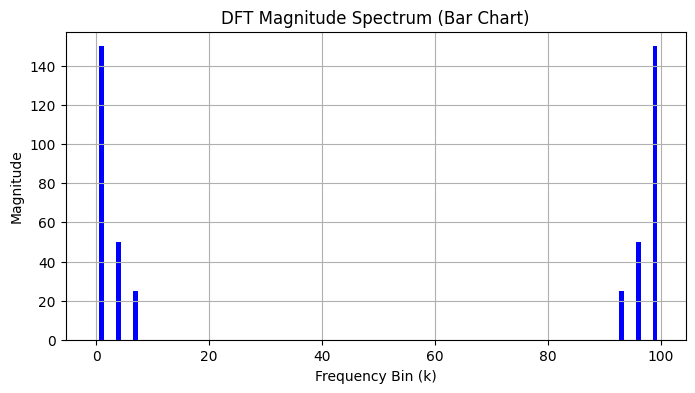

In [4]:
# Loading DFT results

# Load the DFT result from file. Each line: k, dftReal, dftImag.
data = np.loadtxt("dft_results.txt")
k = data[:, 0]
dftReal = data[:, 1]
dftImag = data[:, 2]

# Compute the magnitude of the DFT
dftMag = np.sqrt(dftReal**2 + dftImag**2)

# Plot
fig = plt.figure(figsize=(8, 4))
plt.bar(k, dftMag, color='b')
plt.xlabel("Frequency Bin (k)")
plt.ylabel("Magnitude")
plt.title("DFT Magnitude Spectrum (Bar Chart)")
plt.grid(True)
plt.show()
fig.savefig('dft.png')

As we can see from comparison with [Python Numerical Methods](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html) code results (also kept in the Appendix section of this Notebook), the parallel DFT implementation seems to be working as we would expect, comparing the results.

## 2. Comparison of different input size (N) and number of processes (n)

With DFT working correctly on the test case, we can move to benchmarking for different sizes of input $N$ and different number of cores $n$. We also want to run `numpy` FFT implementation to see how parallel (but naive) $O(N^2)$ algorithm compares to $O(N \log N)$ FFT.

In [5]:
%%bash
# Compile the PETSc C code and set all important PETSc envars

export PETSC_DIR="${HOME}/petsc"
export PETSC_ARCH="arch-linux-c-opt"
export LD_LIBRARY_PATH="${PETSC_DIR}/${PETSC_ARCH}/lib:${LD_LIBRARY_PATH}"

mpicc dft_random.c dft_lib.c -o dft_random \
  -I${PETSC_DIR}/include \
  -I${PETSC_DIR}/${PETSC_ARCH}/include \
  -L${PETSC_DIR}/${PETSC_ARCH}/lib \
  -lpetsc -lm \
  -Wl,-rpath,${PETSC_DIR}/${PETSC_ARCH}/lib

In [6]:
import subprocess
import re
import numpy as np
import matplotlib.pyplot as plt
import timeit

# Define the range of input sizes (N) and number of processes.
N_values = [1000, 5000, 10000, 25000, 50000, 75000, 100000]
nproc_values = [1, 4, 8, 12]

# This dictionary will store the runtime for each nproc.
# For each key (number of processes), we'll have a list of runtimes corresponding to the different N_values.
runtime_data = {nproc: [] for nproc in nproc_values}
# Add FFT storage
runtime_data["FFT"] = []

# Loop over the number of processes
for N in N_values:
    # Compute FFT runtime
    x = np.random.rand(N)
    fft_time = timeit.timeit(lambda: np.fft.fft(x), number=1)
    runtime_data["FFT"].append(fft_time)

    for nproc in nproc_values:
        cmd = f"mpiexec -n {nproc} ./dft_random -N {N}"
        print(f"Running: {cmd}")
        
        # Run the command and capture its output
        proc = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        output = proc.stdout + proc.stderr
        print(output)
        
        # Extract the compute time from the output
        match = re.search(r"DFT computed in ([0-9.]+) seconds", output)
        runtime = float(match.group(1)) if match else np.nan
        runtime_data[nproc].append(runtime)


Running: mpiexec -n 1 ./dft_random -N 1000
DFT computed in 0.019860 seconds

Running: mpiexec -n 4 ./dft_random -N 1000
DFT computed in 0.009879 seconds

Running: mpiexec -n 8 ./dft_random -N 1000
DFT computed in 0.009107 seconds

Running: mpiexec -n 12 ./dft_random -N 1000
DFT computed in 0.007063 seconds

Running: mpiexec -n 1 ./dft_random -N 5000
DFT computed in 0.515913 seconds

Running: mpiexec -n 4 ./dft_random -N 5000
DFT computed in 0.152441 seconds

Running: mpiexec -n 8 ./dft_random -N 5000
DFT computed in 0.087416 seconds

Running: mpiexec -n 12 ./dft_random -N 5000
DFT computed in 0.092760 seconds

Running: mpiexec -n 1 ./dft_random -N 10000
DFT computed in 2.006096 seconds

Running: mpiexec -n 4 ./dft_random -N 10000
DFT computed in 0.558091 seconds

Running: mpiexec -n 8 ./dft_random -N 10000
DFT computed in 0.309832 seconds

Running: mpiexec -n 12 ./dft_random -N 10000
DFT computed in 0.250045 seconds

Running: mpiexec -n 1 ./dft_random -N 25000
DFT computed in 12.476007

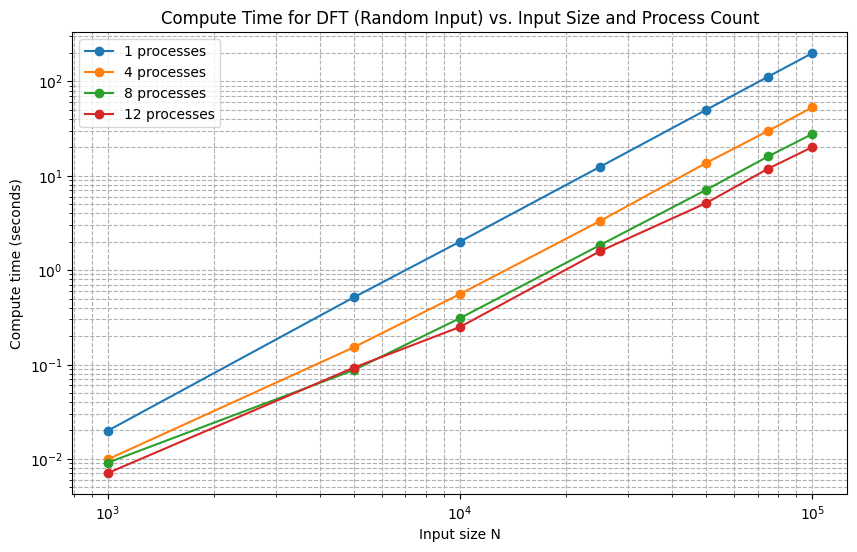

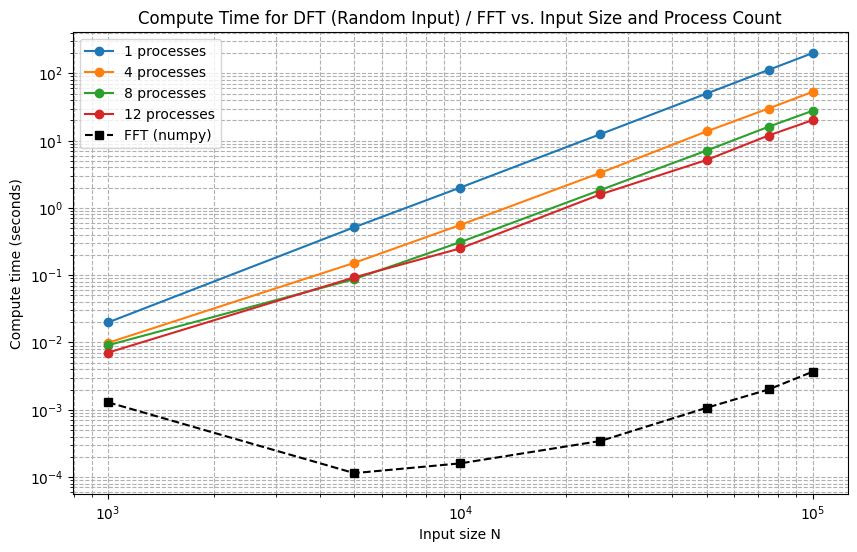

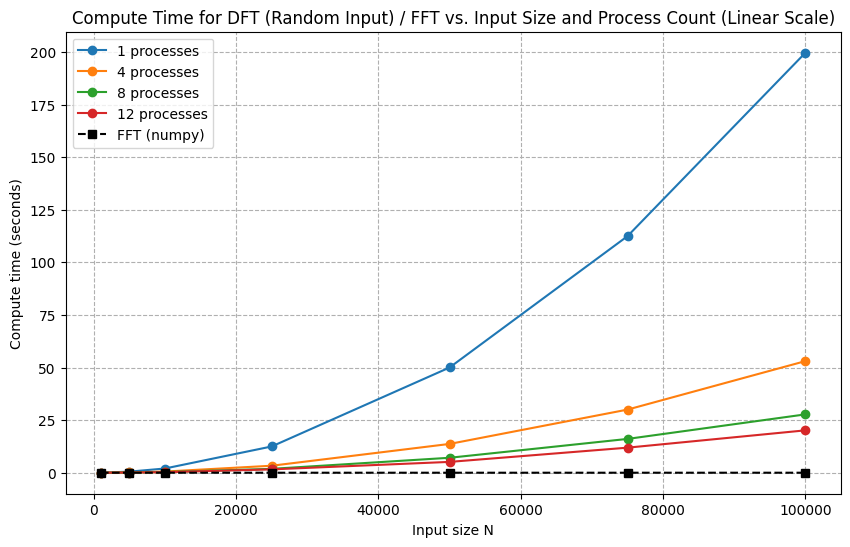

In [7]:
# Now, plot the results.
fig = plt.figure(figsize=(10, 6))
for nproc in nproc_values:
    plt.plot(N_values, runtime_data[nproc], marker='o', label=f"{nproc} processes")
plt.xlabel("Input size N")
plt.ylabel("Compute time (seconds)")
plt.title("Compute Time for DFT (Random Input) vs. Input Size and Process Count")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--")
plt.show()
fig.savefig('log.png')

# Now, plot the results.
fig = plt.figure(figsize=(10, 6))
for nproc in nproc_values:
    plt.plot(N_values, runtime_data[nproc], marker='o', label=f"{nproc} processes")
plt.plot(N_values, runtime_data["FFT"], marker='s', linestyle='--', label="FFT (numpy)", color='black')
plt.xlabel("Input size N")
plt.ylabel("Compute time (seconds)")
plt.title("Compute Time for DFT (Random Input) / FFT vs. Input Size and Process Count")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--")
plt.show()
fig.savefig('log_fft.png')

# Plot non-logarithmic version
fig = plt.figure(figsize=(10, 6))
for nproc in nproc_values:
    plt.plot(N_values, runtime_data[nproc], marker='o', label=f"{nproc} processes")
plt.plot(N_values, runtime_data["FFT"], marker='s', linestyle='--', label="FFT (numpy)", color='black')
plt.xlabel("Input size N")
plt.ylabel("Compute time (seconds)")
plt.title("Compute Time for DFT (Random Input) / FFT vs. Input Size and Process Count (Linear Scale)")
plt.legend()
plt.grid(True, ls="--")
plt.show()
fig.savefig('nolog_fft.png')

## 3. IDFT

The following code checks for correctnes of IDFT by running DFT first and then applying IDFT over the resuls, comparing the initial input and final output, which should be equal.

In [8]:
%%bash
# Compile the PETSc C code and set all important PETSc envars

export PETSC_DIR="${HOME}/petsc"
export PETSC_ARCH="arch-linux-c-opt"
export LD_LIBRARY_PATH="${PETSC_DIR}/${PETSC_ARCH}/lib:${LD_LIBRARY_PATH}"

mpicc dft_idft.c dft_lib.c -o dft_idft \
  -I${PETSC_DIR}/include -I${PETSC_DIR}/${PETSC_ARCH}/include \
  -L${PETSC_DIR}/${PETSC_ARCH}/lib -lpetsc -lm \
  -Wl,-rpath,${PETSC_DIR}/${PETSC_ARCH}/lib

In [9]:
%%bash
# Run DFT and then IDFT sing e.g. 4 cores

mpiexec -n 4 ./dft_idft

Input signal (first 10 samples):
x[0] = 0.720032
x[1] = 0.010022
x[2] = 0.397778
x[3] = 0.103866
] = 0.984052
x[5] = 0.401147
x[6] = 0.144054
x[7] = 0.106773
x[8] = 0.731313
x[9] = 0.180556
Reconstructed signal (first 10 samples):
x_reconstructed[0] = 0.720032 + i0.000000
] = 0.010022 + i0.000000
x_reconstructed[2] = 0.397778 + i0.000000
0.000000tructed[3] = 0.103866 + i
x_reconstructed[4] = 0.984052 + i0.000000
x_reconstructed[5] = 0.401147 + i0.000000
structed[6] = 0.144054 + i0.000000
x_reconstructed[7] = 0.106773 + i0.000000
731313 + i0.000000 = 0.
x_reconstructed[9] = 0.180556 + i0.000000


## Appendix
This section contains code from the DFT section of [Python Numerical Methods](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html). It is used as a comparison to the PETSc implementation, to make sure results are correct.

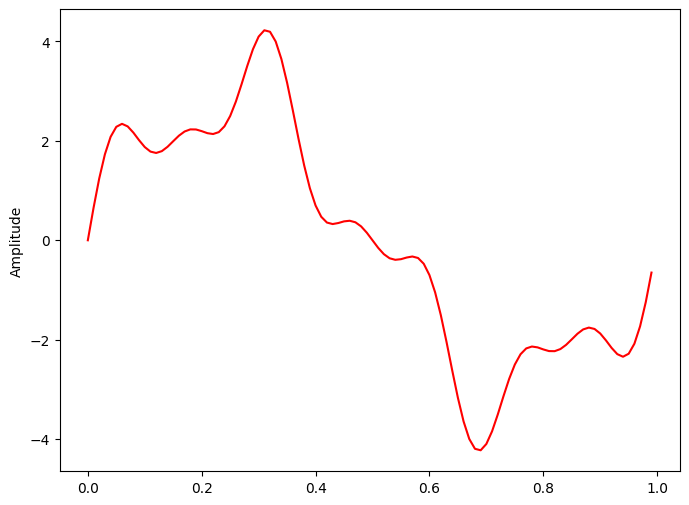

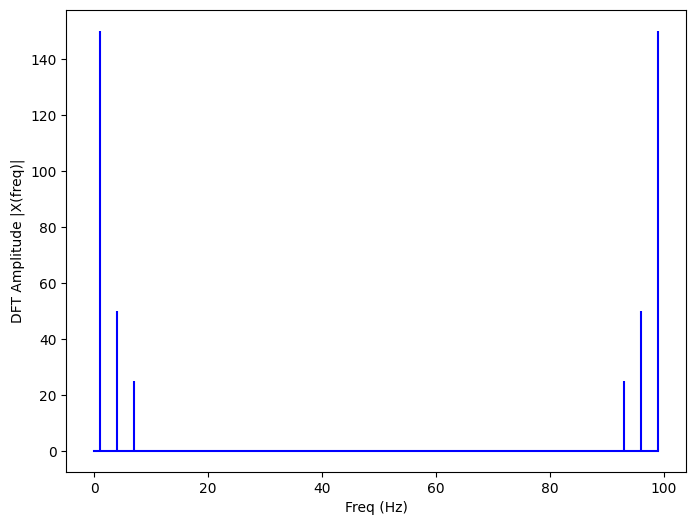

In [10]:
# sampling rate
sr = 100
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

freq = 4
x += np.sin(2*np.pi*freq*t)

freq = 7   
x += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')

plt.show()

def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

X = DFT(x)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (8, 6))
plt.stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.show()